# 随机梯度下降优化器

梯度下降法是机器学习中主流的优化方法。`BrainState`支持常见的梯度下降优化器，包括`SGD`、`Adagrad`、`RMSProp`、`Adam`等。

本章节将介绍如何在`BrainState`中调用优化器，以及如何使用`optax`库中提供的优化器。

In [1]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import brainstate as bst 

构建一个简单的神经网络和损失函数。

In [2]:
class Model(bst.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = bst.nn.Linear(2, 3)
    self.linear2 = bst.nn.Linear(3, 4)
  def __call__(self, x):
    return self.linear2(self.linear1(x))
model = Model()
x = bst.random.randn(1, 2)
y = jnp.ones((1, 4))

### 梯度下降优化器

通常情况下，优化器接受学习率参数`lr`、可训练权重`weights`和特定优化器的其他超参数。

我们以`SGD`优化器作为一个示例：

In [3]:
opt0 = bst.optim.SGD(lr=0.01) # SGD 初始化 lr
opt0.register_trainable_weights(model.states(bst.ParamState)) # SGD 注册可训练权重

In [4]:
def train(opt,loss_fn):
  grads = bst.augment.grad(loss_fn, model.states(bst.ParamState))()
  opt.update(grads)

In [5]:
#初始损失
loss_fn = lambda: ((model(x) - y) ** 2).mean()
loss_fn()

Array(2.258918, dtype=float32)

In [6]:
#单次反向传播
train(opt0,loss_fn)
loss_fn()

Array(2.127218, dtype=float32)



`lr`接受 `float`、`state`和 `LearningRateScheduler` 三种类型的实例。 当接受 `float`和 `state`的实例时，它将被转成`ConstantLR`的实例，`ConstantLR`是一种输出为常值的调度器。实际上,`lr`的类型是调度器。

调度器会根据时间调整返回的学习率值, 常见的调整方法包括指数衰减`ExponentialLR`、阶跃衰减`StepLR`、余弦退火衰减`CosineAnnealingLR`等.

下面给出一个调度器的示例：

In [7]:
lr = bst.optim.ExponentialDecayLR(lr=0.1, decay_steps=2, decay_rate=0.99) # 调度器接受初始学习率lr和其他超参数

In [8]:
def show(steps, rates):
    plt.plot(steps, rates)
    plt.xlabel('Train Step')
    plt.ylabel('Learning Rate')
    plt.show()

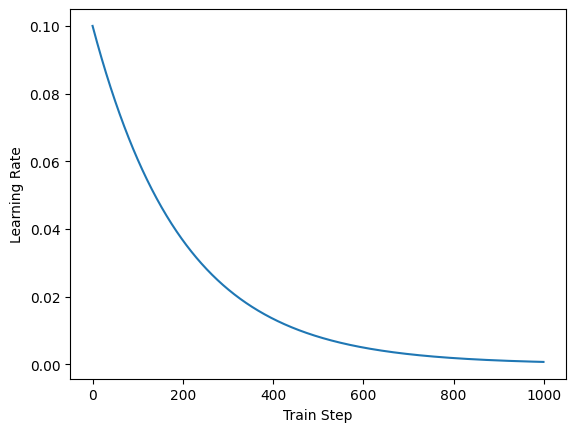

In [9]:
steps = jnp.arange(1000)
rates = lr(steps)

show(steps, rates)

In [10]:
#输出lr类型
lr

ExponentialDecayLR(
  last_epoch=LongTermState(
    value=Array(-1, dtype=int32)
  ),
  last_call=LongTermState(
    value=Array(-1, dtype=int32)
  ),
  decay_steps=2,
  decay_rate=0.99
)

`Scheduler.__call__(i=None)`可以计算当前学习率，若不提供`i`,则输出初始学习率，否则计算第`i`时刻的学习率。

In [11]:
#输出lr的初始学习率
lr()

Array(0.1, dtype=float32)

### 如何使用`optax`库


`optax`库是一个由`DeepMind`开发、基于`JAX`框架构建的`python`库，为深度学习和大规模机器学习提供高效的梯度优化算法。`optax`提供一系列预定义的优化器、调度器和损失函数，允许用户自定义复杂的优化规则，可以轻松组合和实验不同的优化策略。

`BrainState`提供`brainstate.optim.optaxoptimizer`函数，能够将`optax`的优化器实例转化成基于`state`的实例。


In [12]:
optax1 = optax.adam(0.001)
opt1 = bst.optim.OptaxOptimizer(optax1)
opt1.register_trainable_weights(model.states(bst.ParamState))
train(opt1,loss_fn)
loss_fn()

Array(2.1127987, dtype=float32)

我们还可以自由定义优化器，并调用`optax`提供的损失函数。

In [13]:
optax2 = optax.chain(
    optax.scale(-0.1),
    optax.scale_by_adam()
)
opt2 = bst.optim.OptaxOptimizer(optax2)
opt2.register_trainable_weights(model.states(bst.ParamState))

loss_fn = lambda: optax.losses.l2_loss(model(x),y).mean()
train(opt2,loss_fn)
loss_fn()

Array(6.7668295, dtype=float32)